In [1]:
from celmech.maps import CometMap
import numpy as np
from matplotlib import pyplot as plt

# Comet map
This notebook illustrates the `CometMap` class of `celmech`, which implements the symplectic map derived in [Hadden & Tremaine (2024)](https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.3054H/abstract) that describes the dynamics of particles on highly eccentric orbits subject to planetary-mass perturbers. The full map is given by
$$
\begin{align}
x' &= x - 2\mu\partial_\theta F_\beta(\theta)\\
\theta' &= \theta + 2\pi / x'^{3/2}
\end{align}
$$
where mapping variable $x$ is related to the semi-major axes of the particle ($a$) and perturber ($a_\mathrm{pert}$) according to $x = a_\mathrm{pert}/a$, and the mapping variable $\theta$ is the angular location of the perturber, measured relative to the particle when the particle is at pericenter. The parameter $\mu$ is the planet-to-star mass ratio of the perturber and $F_\beta(\theta)$  is a function that depend on the parameter $\beta = a_\mathrm{pert}/q$ where $q$ is the pericenter distance of the particle's orbit (assumed fixed).

The full map given above can be implemented with the `CometMap.full_map` method. The default map implemented by the `CometMap` class implements the "local approximation" of the map in the vicinity of an $N$:1 MMR, and is given by (see Equations 5 & 6 of [Hadden & Tremaine, 2024](https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.3054H/abstract)):
$$
\begin{align}
w' &= w + 3\mu N^{5/3}\partial_\theta F_\beta(\theta)\\
\theta' &= \theta + 2\pi w'
\end{align}
$$
where $\frac{3}{2N}\left({1-\frac{x}{x_0}}\right)$ and $x_0$ is the $x$-value that corresponds to exact $N$:1 resonance. This approximation makes the map periodic in both mapping variables, $\theta$ and $w$.

## Plot phase space
Below, we use the map to make a plot of phase space in the vicinity of the 20:1 MMR with Neptune. The choice of pericenter distances is based on TNO 148 209 (2000 CR105, see Figure 1 of [Hadden & Tremaine (2024)](https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.3054H/abstract).

In [2]:
aNep = 30
q = 44.1
mNep = 5.15e-5
Nres = 20
cmap = CometMap(mNep,Nres,q/aNep,max_kmax=64)

In [3]:
Norbits = 200
orbit_length = 1500
orbits = np.zeros((Norbits,orbit_length,2))
w0s = np.linspace(-0.5,0.5,Norbits,endpoint=False)
for i,w0 in enumerate(w0s):
    theta0 = np.random.uniform(0,2*np.pi)
    X = (theta0,w0)
    orbit = np.zeros((orbit_length,2))
    for j in range(orbit_length):
        orbit[j] = X
        X = cmap(X)
    orbits[i] = orbit

(19.5, 20.5)

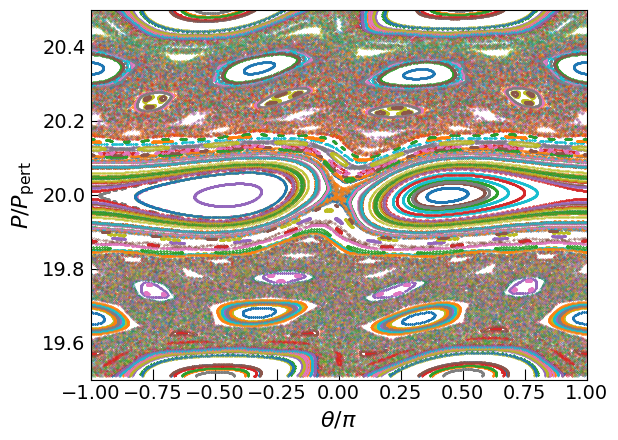

In [4]:
x0 = 20**(-2/3)
for orbit in orbits:
    theta,w = orbit.T
    w = np.mod(w+0.5,1)-0.5
    theta = np.mod(theta+np.pi,2*np.pi)-np.pi
    x = x0*(1 - 2 * w / 3 / cmap.N)
    P = x**(-3/2)
    plt.plot(theta/np.pi,P,'.',ms = 0.5)
plt.xlabel(r"$\theta/\pi$",fontsize=16)
plt.ylabel(r"$P / P_\mathrm{pert}$",fontsize=16)
plt.tick_params(labelsize=14,direction='in',size=8)
plt.xlim(-1,1)
plt.ylim(cmap.N - 0.5,cmap.N + 0.5)

# Resonance overlap and chaotic diffusion rate
In the cells below, the `CometMap` object is used to solve for the semi-major axis at which resonance overlap and dynamical chaos is predicted to occur as a function of pericenter distance. This prediction is based on Equation (14) of [Hadden & Tremaine (2024)](https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.3054H/abstract). The 'quasi-linear' approximation of the diffusion rate is also computed as a function of pericenter, as described in Section 4 of [Hadden & Tremaine (2024)](https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.3054H/abstract). We adopt Neptune's planet-star mass ratio and orbital semi-major axis. The plots below reproduce Figure 3 and Figure 6 of [Hadden & Tremaine, 2024](https://ui.adsabs.harvard.edu/abs/2024MNRAS.527.3054H/abstract))

In [5]:
def euler_totient(n):
    """
    Compute Euler's Totient function φ(n), which counts the number of integers
    from 1 to n that are coprime with n.
    """
    if n == 1:
        return 1
    
    result = n
    p = 2
    while p * p <= n:
        if n % p == 0:
            while n % p == 0:
                n //= p
            result -= result // p
        p += 1

    if n > 1:  # If there's any prime factor left
        result -= result // n

    return result

from scipy.special import gammaincc,gamma

upper_incomplete_gamma = lambda s,x: gammaincc(s,x) * gamma(s)

def solve_a_overlap(cmap):
    tau_div_alpha_54 = np.sqrt(0.5 * (cmap.F(0) - cmap.F(np.pi))) 
    tau_div_alpha_54 += np.sum([euler_totient(k_minus_2+2) * np.sqrt(ck) for k_minus_2,ck in enumerate(cmap.ck[1:])])
    # implement correction to sum described in footnote 4
    lmbda = cmap.lambda_const
    tau_div_alpha_54 += (2/lmbda)**(1.5) * upper_incomplete_gamma(1.5,0.5*lmbda*(cmap.kmax+0.5))
    tau_div_alpha_54 *= 2 * np.sqrt(6*cmap.m / np.pi)
    return (tau_div_alpha_54)**(-4/5)

In [6]:
a_nep = 30
Nq=25
a_overlap = np.zeros(Nq)
diffusion_time = np.zeros(Nq)
P_nep = 30**(3/2)
qs = np.linspace(37,68,Nq)
for i,q in enumerate(qs):
    cmap.q = q / a_nep
    a_overlap[i] = solve_a_overlap(cmap)
    D_QL = 0.5 * np.sum((np.arange(1,cmap.kmax+1)*cmap.ck)**2)
    diffusion_time[i] = 0.25 * P_nep /  D_QL / (cmap.m)**2

(29.0, 69.55)

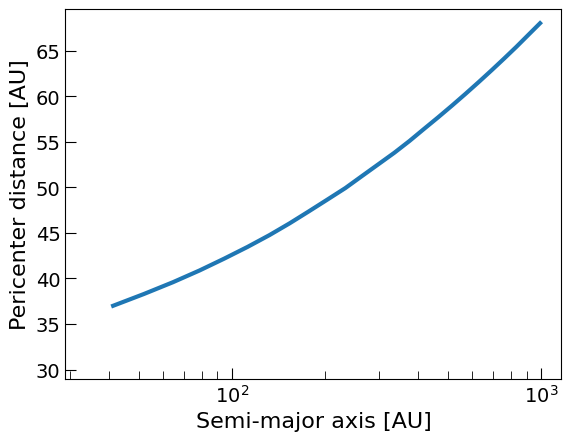

In [7]:
# Compare to Figure 3 of Hadden & Tremaine (2024)
plt.plot(a_nep*a_overlap,qs,lw=3)
plt.xscale('log')
plt.xlabel("Semi-major axis [AU]",fontsize=16)
plt.ylabel("Pericenter distance [AU]",fontsize=16)
plt.tick_params(labelsize=14,direction='in',size=8)
plt.tick_params(direction='in',size=6,which='minor')
plt.xlim(xmin=29)
plt.ylim(ymin=29)

(34.0, 69.55)

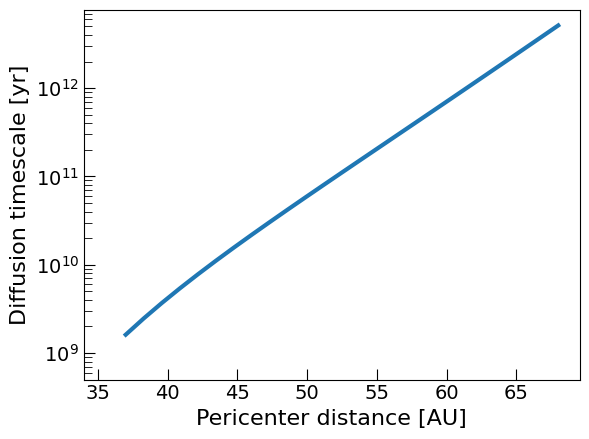

In [8]:
# Compare to Figure 6 of Hadden & Tremaine (2024) 
plt.plot(qs,  diffusion_time,lw=3)
plt.yscale('log')
plt.xlabel("Pericenter distance [AU]",fontsize=16)
plt.ylabel("Diffusion timescale [yr]",fontsize=16)
plt.tick_params(labelsize=14,direction='in',size=8)
plt.tick_params(direction='in',size=6,which='minor')
plt.ylim(ymin=0.5e9)
plt.xlim(xmin = 34)